# Module import

In [1]:
#오류구문
import warnings
warnings.filterwarnings(action='ignore')

#데이터 크롤링
from selenium import webdriver as wd
from selenium.webdriver.support.ui import Select

#전처리 및 데이터 표현
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import datetime as dt
import re

In [2]:
#데이터 시각화
import matplotlib.font_manager as fm 
import matplotlib.pyplot as plt
from matplotlib import rc
font_name = fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
plt.rcParams['font.family'] = font_name

import matplotlib.cm as cm
from matplotlib.colors import Normalize
plt.rcParams['axes.unicode_minus'] = False

#결과분석


# Data Crawling

In [13]:
# 경기정보 크롤링
driver = wd.Chrome(executable_path="chromedriver.exe")

def collect_boxscores(driver, start_day, end_day):
    x = start_day
    matches = []
    
    while x.strftime("%Y-%m-%d") != end_day:
        url = "http://www.statiz.co.kr/boxscore.php?date=" + x.strftime("%Y-%m-%d")
        driver.get(url)
        
        stadium = driver.find_elements_by_class_name("box-title")
        stadiums = []
        for val in stadium:
            stadiums += re.findall('\(([^)]+)', val.text)
        
        for park in stadiums:
            one_match_result = []   # nodename, match result
            match_info = []         # teams, date, scores
            batters = []            # cols of batter boxscore in teamA, teamB
            pitchers = []           # cols of pitcher boxscore in teamA, teamB
            defense = []            # cols of defense boxscore in teamA, teamB
            park_url = "http://www.statiz.co.kr/boxscore.php?date=" + x.strftime("%Y-%m-%d") + "&stadium=" + park
            
            if x.weekday() > 4 :
                park_url += "&hour=14&opt=4"
            else :
                park_url += "&hour=18&opt=4"
            driver.get(park_url)
            
            if driver.find_element_by_xpath("/html/body/div[1]/div[1]/div/section[2]/div/div[1]/div/div[1]/div/div[2]/span").text == ":":
                continue
            
            teamA = driver.find_element_by_xpath("/html/body/div[1]/div[1]/div/section[2]/div/div[1]/div/div[1]/div/div[1]/div/div/div[2]")
            teamB = driver.find_element_by_xpath('/html/body/div[1]/div[1]/div/section[2]/div/div[1]/div/div[1]/div/div[3]/div/div/div/div[2]')
            
            node_name = x.strftime("%m-%d") + ' ' + teamA.text + ' vs ' + teamB.text
            
            # match info
            score = driver.find_element_by_xpath("/html/body/div[1]/div[1]/div/section[2]/div/div[1]/div/div[1]/div/div[2]/span")
            match_info.extend([x.strftime("%Y-%m-%d"), park, teamA.text, teamB.text, score.text])
            
            
            # batter, pitcher boxscore
            contents = driver.find_elements_by_class_name('col-md-12.col-xs-12.col-sm-12.col-lg-12')
            records = contents[1].find_elements_by_class_name('col-xs-12')
            bat_records = []
            pit_records = []
            
            for i, box in enumerate(records):
                if i < 2:
                    bat_records.append(box)
                else:
                    pit_records.append(box)
            
            
            # batters info
            bat_teamA = bat_records[0].find_element_by_class_name('colhead_stz')
            bat_teamB = bat_records[1].find_element_by_class_name('colhead_stz')
            
            A_bat_rec = []
            B_bat_rec = []
            for recs in bat_teamA.find_elements_by_tag_name('td'):
                A_bat_rec.append(recs.text)
            A_bat_rec[0] = 'A팀'
            
            for recs in bat_teamB.find_elements_by_tag_name('td'):
                B_bat_rec.append(recs.text)
            B_bat_rec[0] = 'B팀'
            batters.extend([A_bat_rec, B_bat_rec])
            
            
            # pitchers info
            pit_teamA = pit_records[0].find_element_by_class_name('colhead_stz')
            pit_teamB = pit_records[1].find_element_by_class_name('colhead_stz')
            
            A_pit_rec = []
            B_pit_rec = []
            for recs in pit_teamA.find_elements_by_tag_name('td'):
                A_pit_rec.append(recs.text)
            A_pit_rec[0] = 'A팀'
            
            for recs in pit_teamB.find_elements_by_tag_name('td'):
                B_pit_rec.append(recs.text)
            B_pit_rec[0] = 'B팀'
            pitchers.extend([A_pit_rec, B_pit_rec])
            
            
            # defense info
            d_contents = driver.find_elements_by_class_name('col-xs-12.col-sm-6')
            A_defense = d_contents[0].find_element_by_class_name('colhead_stz')
            B_defense = d_contents[1].find_element_by_class_name('colhead_stz')
            
            A_def_rec = []
            B_def_rec = []
            for recs in A_defense.find_elements_by_tag_name('td'):
                A_def_rec.append(recs.text)
            A_def_rec[0] = 'A팀'
            
            for recs in B_defense.find_elements_by_tag_name('td'):
                B_def_rec.append(recs.text)
            B_def_rec[0] = 'B팀'
            defense.extend([A_def_rec, B_def_rec])
            
            
            # match summary
            one_match_result.extend([node_name, match_info, batters, pitchers, defense])
            matches.append(one_match_result)
            
        x += dt.timedelta(days=1)
    return matches

In [45]:
# crawling sample
april_matches = collect_boxscores(driver, dt.datetime(2022, 4, 2), "2022-05-01")
april_matches[0][1]

['2022-04-02', '잠실', 'Eagles', 'Bears', '4 : 6']

In [16]:
# crawling all match info
driver = wd.Chrome(executable_path="chromedriver.exe")
next_matches = collect_boxscores(driver, dt.datetime(2022, 5, 1), "2022-10-12")

# Data save

In [52]:
# change match info list to numpy
total_matches = april_matches + next_matches
np_total = np.array(total_matches)

In [3]:
# 각 데이터의 열 컬럼
col_info = ['Date', 'Stardium', 'teamA', 'teamB', 'Score']
col_bat = ['TPA','AB','R','H','HR','RBI','BB','HBP','SO','GO','FO','PIT','GDP','LOB','AVG','OPS','LI','WPA','RE24']
col_pit = ['IP','TBF','H','R','ER','BB','HBP','K','HR','GO-FO','PIT-S','IR-IS','GSC','ERA','WHIP','LI','WPA','RE24']
col_def = ['IP','PO','A','E','_P','_A','GDP']

In [139]:
# 크롤링 데이터 정제

info = np_total[:, 1].tolist()
info_df = pd.DataFrame(info, columns=col_info)
info_df["NodeName"] = np_total[:, 0]
info_df = info_df[['NodeName']+col_info]
# info_df.head(5)

bat_list = np_total[:, 2].tolist()
bat_arr = np.array(bat_list)
bat_A_df = pd.DataFrame(bat_arr[:, 0], columns=['team']+col_bat)
bat_A_df["NodeName"] = np_total[:, 0]
bat_A_df = bat_A_df[['NodeName', 'team']+col_bat]
# bat_A_df.head(5)

bat_arr = np.array(bat_list)
bat_B_df = pd.DataFrame(bat_arr[:, 1], columns=['team']+col_bat)
bat_B_df["NodeName"] = np_total[:, 0]
bat_B_df = bat_B_df[['NodeName', 'team']+col_bat]
# bat_B_df.head(5)

pit_list = np_total[:, 3].tolist()
pit_arr = np.array(pit_list)
pit_A_df = pd.DataFrame(pit_arr[:, 0], columns=['team']+col_pit)
pit_A_df["NodeName"] = np_total[:, 0]
pit_A_df = pit_A_df[['NodeName', 'team']+col_pit]
# pit_A_df.head(5)

pit_arr = np.array(pit_list)
pit_B_df = pd.DataFrame(pit_arr[:, 1], columns=['team']+col_pit)
pit_B_df["NodeName"] = np_total[:, 0]
pit_B_df = pit_B_df[['NodeName', 'team']+col_pit]
# pit_B_df.head(5)

def_list = np_total[:, 4].tolist()
def_arr = np.array(def_list)
def_A_df = pd.DataFrame(def_arr[:, 0], columns=['team']+col_def)
def_A_df["NodeName"] = np_total[:, 0]
def_A_df = def_A_df[['NodeName', 'team']+col_def]
# def_A_df.head(5)

def_arr = np.array(def_list)
def_B_df = pd.DataFrame(def_arr[:, 1], columns=['team']+col_def)
def_B_df["NodeName"] = np_total[:, 0]
def_B_df = def_B_df[['NodeName', 'team']+col_def]
# def_B_df.head(5)

In [143]:
# Data save
info_df.to_excel('./crawling_data/match_info.xlsx')
bat_A_df.to_excel('./crawling_data/teamA_batting.xlsx')
bat_B_df.to_excel('./crawling_data/teamB_batting.xlsx')
pit_A_df.to_excel('./crawling_data/teamA_pitching.xlsx')
pit_B_df.to_excel('./crawling_data/teamB_pitching.xlsx')
def_A_df.to_excel('./crawling_data/teamA_defence.xlsx')
def_B_df.to_excel('./crawling_data/teamB_defence.xlsx')

# Data cleansing

## Data load

In [4]:
info_df = pd.read_excel('./crawling_data/match_info.xlsx')
bat_A_df = pd.read_excel('./crawling_data/teamA_batting.xlsx')
bat_B_df = pd.read_excel('./crawling_data/teamB_batting.xlsx')
pit_A_df = pd.read_excel('./crawling_data/teamA_pitching.xlsx')
pit_B_df = pd.read_excel('./crawling_data/teamB_pitching.xlsx')
def_A_df = pd.read_excel('./crawling_data/teamA_defence.xlsx')
def_B_df = pd.read_excel('./crawling_data/teamB_defence.xlsx')

In [5]:
info_df.drop(['Unnamed: 0'],axis=1, inplace=True)
bat_A_df.drop(['Unnamed: 0'],axis=1, inplace=True)
bat_B_df.drop(['Unnamed: 0'],axis=1, inplace=True)
pit_A_df.drop(['Unnamed: 0'],axis=1, inplace=True)
pit_B_df.drop(['Unnamed: 0'],axis=1, inplace=True)
def_A_df.drop(['Unnamed: 0'],axis=1, inplace=True)
def_B_df.drop(['Unnamed: 0'],axis=1, inplace=True)

## 1) 경기 결과(경기 승자) 열 추가

In [6]:
# 팀 정보에서 승자 결정
scores = info_df.Score.str.split(" : ")
score_A = scores.str.get(0)
score_B = scores.str.get(1)
info_df['scoreA'], info_df['scoreB'] = (score_A, score_B)
info_df['win'] = np.where(info_df['scoreA'] > info_df['scoreB'], 'A', np.where(info_df['scoreB'] > info_df['scoreA'], 'B', 'D'))
info_df.head(5)

,NodeName,Date,Stardium,teamA,teamB,Score,scoreA,scoreB,win
0,04-02 Eagles vs Bears,2022-04-02,잠실,Eagles,Bears,4 : 6,4,6,B
1,04-02 Landers vs Dinos,2022-04-02,창원NC파크,Landers,Dinos,4 : 0,4,0,A
2,04-02 Lions vs kt,2022-04-02,케이티위즈파크,Lions,kt,1 : 4,1,4,B
3,04-02 Twins vs Tigers,2022-04-02,챔피언스필드,Twins,Tigers,9 : 0,9,0,A
4,04-02 Giants vs Kiwoom,2022-04-02,고척돔,Giants,Kiwoom,7 : 2,7,2,A


## 2) 가중치 전처리

## 2-1) 투수 기록 전처리

In [7]:
# 모든 투수의 이닝 수 합 제거
pit_A_df.drop(['IP'], axis=1, inplace=True)
pit_B_df.drop(['IP'], axis=1, inplace=True)

# GO-FO(땅볼아웃-뜬공아웃) 비율로 변환 - GO / FO
gofo = pit_A_df['GO-FO'].str.split("-")
go = gofo.str.get(0)
fo = gofo.str.get(1)
gopfo = go.astype('float32')/fo.astype('float32')
pit_A_df['GOPFO'] = gopfo
gofo = pit_B_df['GO-FO'].str.split("-")
go = gofo.str.get(0)
fo = gofo.str.get(1)
gopfo = go.astype('float32')/fo.astype('float32')
pit_B_df['GOPFO'] = gopfo

# PIT-S 비율로 변환 - S / PIT
pits = pit_A_df['PIT-S'].str.split("-")
pit = pits.str.get(0)
s = pits.str.get(1)
sppit = s.astype('float32')/pit.astype('float32')
pit_A_df['SPPIT'] = sppit
pits = pit_B_df['PIT-S'].str.split("-")
pit = pits.str.get(0)
s = pits.str.get(1)
sppit = s.astype('float32')/pit.astype('float32')
pit_B_df['SPPIT'] = sppit

# IR, RS 분리
iris = pit_A_df['IR-IS'].str.split("-")
ir = iris.str.get(0)
iS = iris.str.get(1)
pit_A_df['IR'] = ir
pit_A_df['IS'] = iS
iris = pit_B_df['IR-IS'].str.split("-")
ir = iris.str.get(0)
iS = iris.str.get(1)
pit_B_df['IR'] = ir
pit_B_df['IS'] = iS

# 기존 열 제거
pit_A_df.drop(['GO-FO', 'PIT-S', 'IR-IS'], axis=1, inplace=True)
pit_B_df.drop(['GO-FO', 'PIT-S', 'IR-IS'], axis=1, inplace=True)

In [8]:
col_pit_cleansed = ['TBF','H','R','ER','BB','HBP','K','HR','GSC','ERA','WHIP','LI','WPA','RE24','GOPFO','SPPIT','IR','IS']
pit_A_df.head(5)

,NodeName,team,TBF,H,R,ER,BB,HBP,K,HR,GSC,ERA,WHIP,LI,WPA,RE24,GOPFO,SPPIT,IR,IS
0,04-02 Eagles vs Bears,A팀,35,9,6,5,3,0,4,1,29,5.63,1.50,0.9,-0.359,-1.56,0.900000,0.651852,3,0
1,04-02 Landers vs Dinos,A팀,31,0,0,0,1,0,11,0,96,0.00,0.10,0.9,0.705,5.55,0.900000,0.693548,0,0
2,04-02 Lions vs kt,A팀,38,11,4,4,5,0,4,0,50,4.50,2.00,1.0,-0.069,0.44,1.833333,0.595890,4,0
3,04-02 Twins vs Tigers,A팀,34,3,0,0,3,2,10,0,76,0.00,0.67,0.7,0.352,4.99,0.600000,0.677419,5,0
4,04-02 Giants vs Kiwoom,A팀,39,9,2,2,3,0,11,0,55,2.00,1.33,1.0,0.354,2.99,0.600000,0.655844,1,0


## 2-2) 승자 열을 이용하여 각 변수들의 가중치 계산

In [9]:
def make_weights(match_result, A_record, B_record, columns):
    weighted_records = match_result.copy()
    weighted_records[columns] = pd.DataFrame([[np.nan for _ in range(len(columns))]])
    for i, row in weighted_records.iterrows():
        if row['win'] == 'A':
            weighted_records.loc[i, 2:] = A_record.iloc[i, 2:].astype('float32') - B_record.iloc[i, 2:].astype('float32')
        elif row['win'] == 'B':
            weighted_records.loc[i, 2:] = B_record.iloc[i, 2:].astype('float32') - A_record.iloc[i, 2:].astype('float32')
    weighted_records = weighted_records.dropna()
    weighted_records.reset_index(drop=True, inplace=True)
    return weighted_records

win_bat_weights = make_weights(info_df[['NodeName', 'win']], bat_A_df, bat_B_df, col_bat)
win_pit_weights = make_weights(info_df[['NodeName', 'win']], pit_A_df, pit_B_df, col_pit_cleansed)
win_def_weights = make_weights(info_df[['NodeName', 'win']], def_A_df, def_B_df, col_def)

## 2-3) 계산 결과가 일정한 가중치 제거

In [10]:
# 계산 결과가 일정한 가중치

print("GDP\n", win_def_weights['GDP'].value_counts()) # 모든 값이 0
print('PO\n', win_def_weights['PO'].value_counts()) # 한 경기의 아웃 수는 결국 이닝수*3으로 경기에 기여한다고 보기에 적합하지 않음
# print('WPA\n', win_bat_weights['WPA'].value_counts()) # 계산량이 상대적이라 수치가 고정
print('IP\n', win_def_weights['IP'].value_counts()) # 총 이닝 수로 사용이 적합하지 않음

GDP
 0.0    708
Name: GDP, dtype: int64
PO
  0.0    353
 3.0    272
-3.0     30
 1.0     25
 2.0     22
-1.0      4
-2.0      2
Name: PO, dtype: int64
IP
  0.0    358
 9.0    272
-9.0     31
 3.0     23
 6.0     22
-6.0      1
-3.0      1
Name: IP, dtype: int64


In [11]:
win_def_weights.drop(['GDP', 'IP', 'PO'], axis=1, inplace=True)
win_bat_weights.drop('WPA', axis=1, inplace=True)
win_pit_weights.drop('WPA', axis=1, inplace=True)

col_def_cleansed = col_def[:]
col_def_cleansed.remove('GDP')
col_def_cleansed.remove('IP')
col_def_cleansed.remove('PO')
col_bat_cleansed = col_bat[:]
col_bat_cleansed.remove('WPA')
col_pit_cleansed.remove('WPA')

## 2-4) 각 수치 정규화

In [12]:
win_bat_weights_normalized = win_bat_weights.copy()
win_bat_weights_normalized[col_bat_cleansed] = (win_bat_weights_normalized[col_bat_cleansed] - win_bat_weights_normalized[col_bat_cleansed].min()) / (win_bat_weights_normalized[col_bat_cleansed].max() - win_bat_weights_normalized[col_bat_cleansed].min())

win_pit_weights_normalized = win_pit_weights.copy()
win_pit_weights_normalized[col_pit_cleansed] = (win_pit_weights_normalized[col_pit_cleansed] - win_pit_weights_normalized[col_pit_cleansed].min()) / (win_pit_weights_normalized[col_pit_cleansed].max() - win_pit_weights_normalized[col_pit_cleansed].min())

win_def_weights_normalized = win_def_weights.copy()
win_def_weights_normalized[col_def_cleansed] = (win_def_weights_normalized[col_def_cleansed] - win_def_weights_normalized[col_def_cleansed].min()) / (win_def_weights_normalized[col_def_cleansed].max() - win_def_weights_normalized[col_def_cleansed].min())

## 3) 가중치 통합

## 3-1) 중복 확인

In [13]:
# 중복 가중치 확인
all_weights = col_bat + col_pit_cleansed + col_def_cleansed
weights_count = dict.fromkeys(all_weights)

print("중복 가중치")
for i in weights_count:
    if all_weights.count(i) != 1:
        print(i, ":", all_weights.count(i))

중복 가중치
R : 2
H : 2
HR : 2
BB : 2
HBP : 2
LI : 2
RE24 : 2


## 중복 가중치 분류
### 중복가중치별 설명
R : 득점, H : 안타, HR : 홈런, BB : 볼넷, HBP : 데드볼, LI : 승부의 중요한 순간에 타석에 선 정도, RE24 : 기대득점
<br>
### 가중치 통합 기준
행위의 주체자로 구분<br>
 - R, H, HR, Li, RE24 : 타자 통계 사용<br>
 - BB, HBP : 투수 통계 사용<br><br>

In [14]:
# 행위의 주체자로 구분
dup_bat_sub = ['R', 'H', 'HR', 'LI', 'RE24']
dup_pit_sub = ['BB', 'HBP']

## 3-2) 분류별 가중치 통합

In [15]:
col_bat_subject = col_bat_cleansed[:]
col_pit_subject = col_pit_cleansed[:]

for ele in dup_pit_sub :
    col_bat_subject.remove(ele)

for ele in dup_bat_sub :
    col_pit_subject.remove(ele)

In [16]:
win_weights_sub = pd.concat([win_bat_weights[['NodeName', 'win']+col_bat_subject], win_pit_weights[col_pit_subject], win_def_weights.iloc[:, 2:]], axis=1)
win_weights_sub_nz = pd.concat([win_bat_weights_normalized[['NodeName', 'win']+col_bat_subject], win_pit_weights_normalized[col_pit_subject], win_def_weights_normalized.iloc[:, 2:]], axis=1)

In [161]:
# 결과
display(win_weights_sub)
# display(win_weights_sub_nz.iloc[:, :15].head())

,NodeName,win,TPA,AB,R,H,HR,RBI,SO,GO,...,ERA,WHIP,GOPFO,SPPIT,IR,IS,A,E,_P,_A
0,04-02 Eagles vs Bears,B,-6.0,-4.0,2.0,-1.0,1.0,2.0,-7.0,1.0,...,-1.63,0.17,0.242857,-0.012100,-2.0,0.0,-5.0,-1.0,-2.0,1.0
1,04-02 Landers vs Dinos,A,11.0,6.0,4.0,8.0,0.0,4.0,-3.0,1.0,...,-3.60,-1.00,-0.100000,-0.007841,-4.0,-3.0,0.0,0.0,0.0,0.0
2,04-02 Lions vs kt,B,8.0,3.0,3.0,9.0,0.0,3.0,-1.0,4.0,...,-3.50,-1.67,-1.366667,0.076837,-4.0,0.0,-7.0,0.0,0.0,0.0
3,04-02 Twins vs Tigers,A,5.0,4.0,9.0,3.0,1.0,9.0,0.0,2.0,...,-5.00,-0.33,-0.288889,0.013297,5.0,0.0,-2.0,-3.0,-3.0,0.0
4,04-02 Giants vs Kiwoom,A,1.0,0.0,5.0,0.0,0.0,4.0,0.0,5.0,...,-1.00,-0.11,-1.600000,-0.027700,1.0,0.0,-5.0,-1.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,10-08 kt vs Tigers,A,1.0,2.0,5.0,1.0,2.0,5.0,-3.0,-6.0,...,-4.00,0.00,0.725146,0.087151,2.0,0.0,8.0,-1.0,-1.0,0.0
704,10-08 Twins vs Giants,B,-1.0,-4.0,1.0,0.0,1.0,1.0,-3.0,1.0,...,-1.38,-0.31,-0.583333,0.030364,-3.0,-1.0,-3.0,0.0,1.0,-1.0
705,10-08 Eagles vs Dinos,B,-4.0,1.0,1.0,3.0,0.0,2.0,0.0,2.0,...,-1.01,0.01,-0.400000,-0.106590,3.0,0.0,-2.0,1.0,1.0,0.0
706,10-10 Dinos vs kt,B,-3.0,-5.0,3.0,-1.0,2.0,3.0,-4.0,-1.0,...,-3.63,-0.14,0.208333,0.039420,1.0,0.0,3.0,1.0,1.0,0.0


# Make graph

In [17]:
# 가중치에 따라 경기와 요인 노드를 연결
def connect_match_factor(df, df_nz, nodes):
    edges = []
    for i in range(len(df)):
        for j in range(len(nodes)):
            if df.iloc[i, j+2] > 0:
                edges.append((i, nodes[j], df_nz.iloc[i, j+2])) # {"weight":df_nz.iloc[i, j+2], 'distance':(abs(df_nz.iloc[i, j+2]-1)+1)}
    return edges  

# 모든 요인노드와 경기 결과노드를 연결
def match_contributed_factor_all(df, nodes):
    edges = []
    for i in range(len(nodes)):
        edges.append((nodes[i], 'win', 1)) # {"weight":1, 'distance':1}
    return edges

# 그래프 제작 함수
def make_all_graph(graph, df, df_nz):
    # add match nodes
    graph.add_nodes_from(range(len(df)))
    graph.add_node('win')
    
    # make factor nodes
    weight_nodes = df.columns[2:].tolist()
    graph.add_nodes_from(weight_nodes)
    
    # connect matches and factors
    weight_edges = connect_match_factor(df, df_nz, weight_nodes)
    graph.add_weighted_edges_from(weight_edges)
    
    # connect factors and match result
    contributed_edges = match_contributed_factor_all(df, weight_nodes)
    graph.add_weighted_edges_from(contributed_edges)
    
    return weight_nodes, weight_edges, contributed_edges

In [18]:
# 그래프 생성
graph_all = nx.DiGraph()

# 그래프 노드, 엣지 할당
wns, wes, ces = make_all_graph(graph_all, win_weights_sub, win_weights_sub_nz)

In [19]:
# 각 중심성 구하기
all_between = nx.betweenness_centrality(graph_all)
all_close = nx.closeness_centrality(graph_all)
all_pagerank = nx.pagerank(graph_all)

In [20]:
# 중심성 딕셔너리로부터 각 요인에 해당하는 값들 분류
all_between_cent = {}
all_close_cent = {}
all_pagerank_cent = {}

for i in range(len(wns)):
    all_between_cent[wns[i]] = [all_between[wns[i]]]
    all_close_cent[wns[i]] = [all_close[wns[i]]]
    all_pagerank_cent[wns[i]] = [all_pagerank[wns[i]]]
        
all_centrality = [all_between_cent, all_pagerank_cent, all_close_cent]

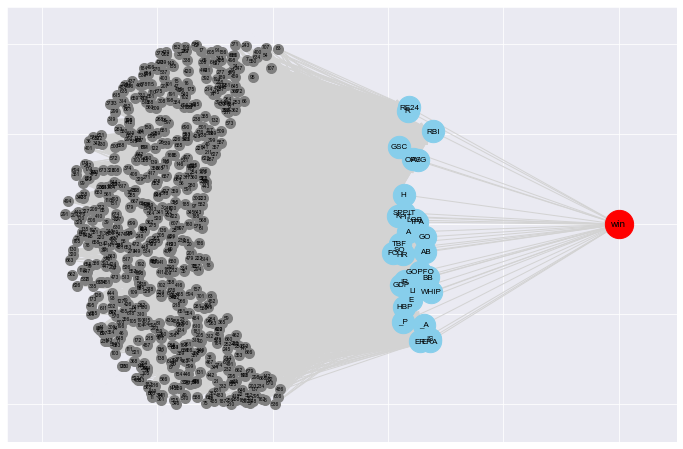

In [126]:
# 그래프 시각화

import random

def draw_graph(graph, df, centrality, networkname, node_size=100):
    matches = graph.subgraph(range(len(df)))
    features = graph.subgraph(list(centrality.keys()))
    match_result = graph.subgraph(['win'])
    
    pos = {}
    pos['win'] = (2, 0)
    for i in range(len(df)):
        t = random.uniform(-1, 1)
        x = random.uniform((t**2)*2/5 - 0.4, (t**2)*2/5 + 0.2)
        pos[i] = np.array([x, t]).astype('float64')
#         pos[i] = (random.uniform(0, 0.4), random.uniform(0, 1))
    
    maxc = max(centrality.values())[0]
    minc = min(centrality.values())[0]
    for fea, cen in centrality.items():
        pos[fea] = np.array([random.uniform(1, 1.2), ((cen - minc) / (maxc - minc) - 0.5)*1.3]).astype('float64')
    
    plt.figure(figsize=(12, 8))
    
    # matches
    nx.draw_networkx_nodes(matches, pos=pos, node_size=node_size, node_color='grey')
    nx.draw_networkx_labels(matches, pos=pos, font_size=5, font_color='black')
    
    # features
    nx.draw_networkx_nodes(features, pos=pos, node_size=500, node_color='skyblue')
    nx.draw_networkx_labels(features, pos=pos, font_size=8, font_color='black')
    
    # match_results
    nx.draw_networkx_nodes(match_result, pos=pos, node_size=800, node_color='red')
    nx.draw_networkx_labels(match_result, pos=pos, font_size=10, font_color='black')
    
    # edges
    nx.draw_networkx_edges(graph, pos=pos, edge_color='lightgrey')
    
    plt.savefig(networkname)
    plt.show()

draw_graph(graph_all, win_weights_sub, all_pagerank_cent, 'all_nodes.png')

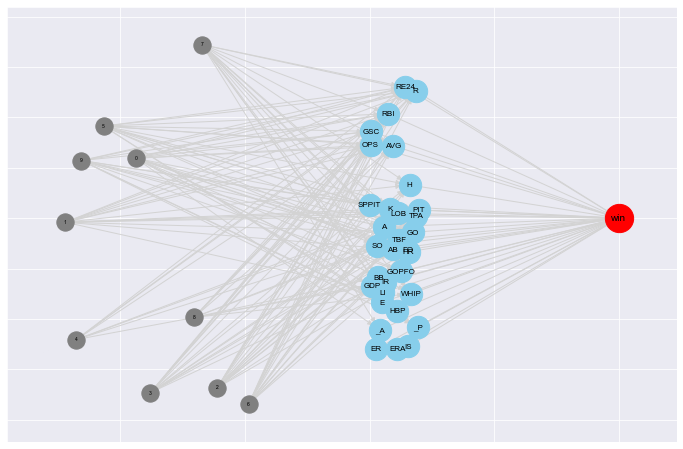

In [127]:
# 소규모 그래프 생성
graph_10 = nx.DiGraph()

# 그래프 노드, 엣지 할당
wns_10, wes_10, ces_10 = make_all_graph(graph_10, win_weights_sub[:10], win_weights_sub_nz[:10])

# 시각화
draw_graph(graph_10, win_weights_sub[:10], all_pagerank_cent, '10_nodes.png', node_size=300)

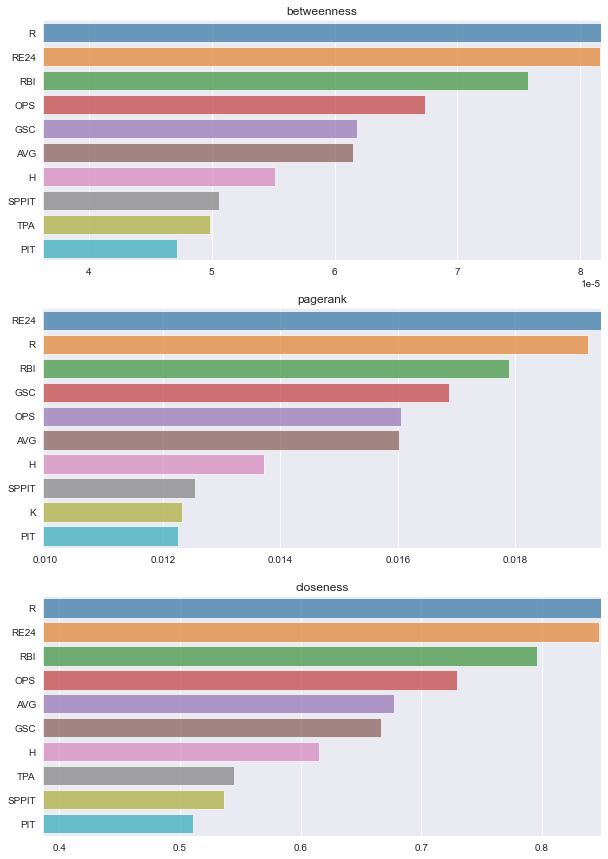

In [22]:
# 중심성 수치 시각화(상위10)
fig , axes = plt.subplots(3, 1, figsize = (10, 15)) 
names = ['betweenness', 'pagerank', 'closeness']

for i, ax in enumerate(axes.ravel()):
    cent = all_centrality[i]
#     print(cent)
    cent_sorted = ((pd.DataFrame(cent)).sum().sort_values(ascending=False)) # , columns=win_weights_sub.columns[2:]
#     print(cent_sorted)
    t = sns.barplot(ax=ax, y=(cent_sorted[:10]).index, x=(cent_sorted[:10]), alpha=0.7)
    t.set(xlim=(cent_sorted[int(len(cent_sorted)/2)], cent_sorted[0]))
    sns.set_style("darkgrid")
    ax.set_title(names[i])

plt.show()

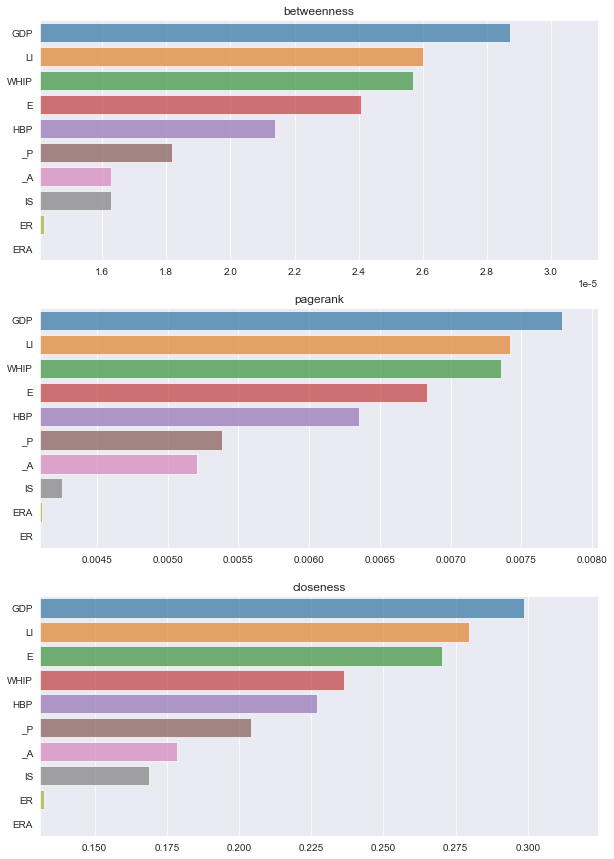

In [23]:
# 중심성 수치 시각화(하위10)
fig , axes = plt.subplots(3, 1, figsize = (10, 15)) 
names = ['betweenness', 'pagerank', 'closeness']

for i, ax in enumerate(axes.ravel()):
    cent = all_centrality[i]
#     print(cent)
    cent_sorted = ((pd.DataFrame(cent)).sum().sort_values(ascending=True)) # , columns=win_weights_sub.columns[2:]
#     print(cent_sorted)
    t = sns.barplot(ax=ax, y=(cent_sorted[:10].sort_values(ascending=False)).index, x=(cent_sorted[:10].sort_values(ascending=False)), alpha=0.7)
    t.set(xlim=(cent_sorted[0], cent_sorted[10]))
    sns.set_style("darkgrid")
    ax.set_title(names[i])

plt.show()

In [24]:
# 그래프 저장
nx.write_gexf(graph_all, "./graph.gexf")

# Result analysis

## 데이터 변환
# 평가지표
1) 상관계수 : 경기 결과와 각 변수가 가지는 상관관계를 기준으로 그래프 중심성 평가<br
                                                   >
2) 머신러닝 모델 변수 중요도 : 머신러닝 모델이 경기 결과를 예측하는데에 사용된 각 변수가 모델에 영향을 미친 정도를 기준으로 그래프 중심성 평가

### 상관관계 파악, 기계학습을 위한 label, feature 선정
 - label : 팀A가 승리한 경우 1, 패배한 경우 0
 - feature : 모든 연속형 feature값을 팀A - 팀B로 변환

In [25]:
# 기존 데이터 확인
before_df = win_weights_sub.copy()
before_df.head(5)

,NodeName,win,TPA,AB,R,H,HR,RBI,SO,GO,...,ERA,WHIP,GOPFO,SPPIT,IR,IS,A,E,_P,_A
0,04-02 Eagles vs Bears,B,-6.0,-4.0,2.0,-1.0,1.0,2.0,-7.0,1.0,...,-1.63,0.17,0.242857,-0.012100,-2.0,0.0,-5.0,-1.0,-2.0,1.0
1,04-02 Landers vs Dinos,A,11.0,6.0,4.0,8.0,0.0,4.0,-3.0,1.0,...,-3.60,-1.00,-0.100000,-0.007841,-4.0,-3.0,0.0,0.0,0.0,0.0
2,04-02 Lions vs kt,B,8.0,3.0,3.0,9.0,0.0,3.0,-1.0,4.0,...,-3.50,-1.67,-1.366667,0.076837,-4.0,0.0,-7.0,0.0,0.0,0.0
3,04-02 Twins vs Tigers,A,5.0,4.0,9.0,3.0,1.0,9.0,0.0,2.0,...,-5.00,-0.33,-0.288889,0.013297,5.0,0.0,-2.0,-3.0,-3.0,0.0
4,04-02 Giants vs Kiwoom,A,1.0,0.0,5.0,0.0,0.0,4.0,0.0,5.0,...,-1.00,-0.11,-1.600000,-0.027700,1.0,0.0,-5.0,-1.0,0.0,-1.0


In [26]:
# label 추가 및 feature값 변환
processed_1_df = before_df.copy()
processed_1_df['label'] = np.where(processed_1_df['win'] == 'A', 1, 0)
features = processed_1_df.iloc[:, 2:-1].columns
processed_1_df.loc[processed_1_df['label'] == 0, features] *= (-1)
processed_1_df = processed_1_df.replace(-0.0, 0.0)
processed_2_df = processed_1_df.copy()
processed_2_df.loc[processed_2_df['label'] == 0] = -1

processed_1_df.iloc[:, 2:-1] = (processed_1_df.iloc[:, 2:-1] - processed_1_df.iloc[:, 2:-1].min()) / (processed_1_df.iloc[:, 2:-1].max() - processed_1_df.iloc[:, 2:-1].min())


processed_1_df.head(5)

,NodeName,win,TPA,AB,R,H,HR,RBI,SO,GO,...,WHIP,GOPFO,SPPIT,IR,IS,A,E,_P,_A,label
0,04-02 Eagles vs Bears,B,0.585366,0.500000,0.358974,0.393939,0.4,0.358974,0.739130,0.40,...,0.511811,0.571792,0.545876,0.583333,0.466667,0.692308,0.6,0.750,0.333333,0
1,04-02 Landers vs Dinos,A,0.707317,0.566667,0.512821,0.606061,0.5,0.512821,0.304348,0.50,...,0.348425,0.577669,0.496024,0.333333,0.266667,0.500000,0.5,0.500,0.500000,1
2,04-02 Lions vs kt,B,0.243902,0.266667,0.333333,0.090909,0.5,0.333333,0.478261,0.25,...,0.874016,0.638002,0.323533,0.666667,0.466667,0.769231,0.5,0.500,0.500000,0
3,04-02 Twins vs Tigers,A,0.560976,0.500000,0.641026,0.454545,0.6,0.641026,0.434783,0.55,...,0.480315,0.569899,0.548868,0.708333,0.466667,0.423077,0.2,0.125,0.500000,1
4,04-02 Giants vs Kiwoom,A,0.463415,0.366667,0.538462,0.363636,0.5,0.512821,0.434783,0.70,...,0.523622,0.515965,0.446375,0.541667,0.466667,0.307692,0.4,0.500,0.333333,1


## lable(경기결과)와 각 변수 사이의 상관계수 추출

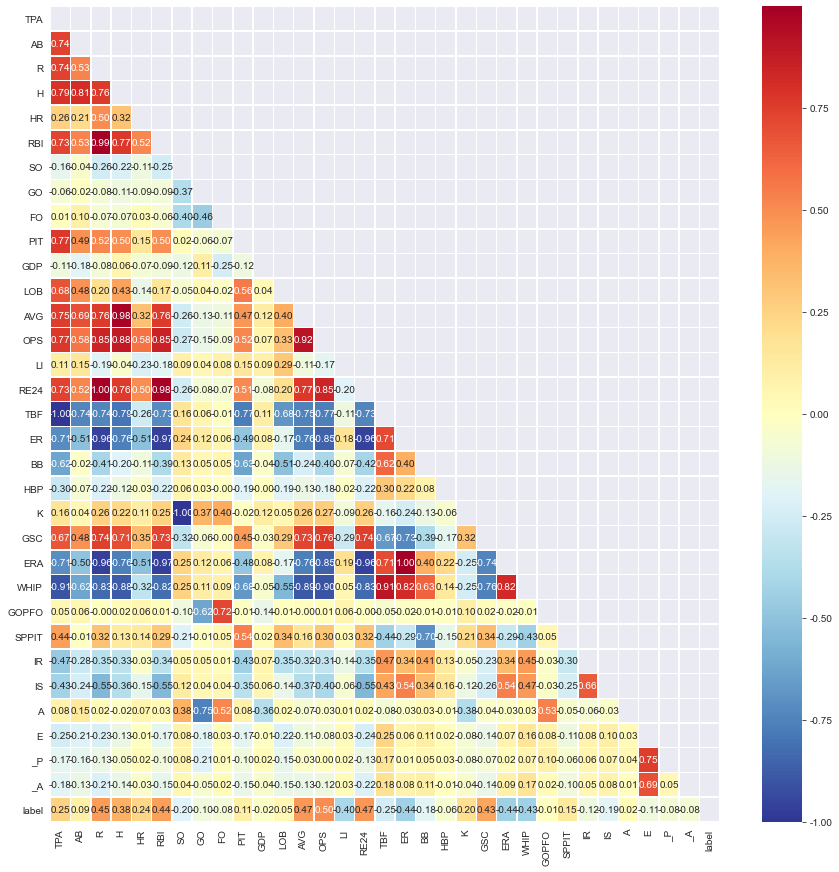

In [27]:
# 각 변수들간의 피어슨 상관계수 출력
def visualize_corr(df):
    plt.figure(figsize=(15, 15))

    mask = np.zeros_like(df.corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    sns.heatmap(data=df.corr(),
                cmap='RdYlBu_r',
                mask=mask,
                annot=True, fmt='.2f',
                linewidth=.5)
    plt.show()

visualize_corr(processed_1_df)

In [28]:
# label과 다른 변수들간의 상관관계
print(processed_1_df.corr()['label'].sort_values(ascending=False)[1:11].index)
abs(processed_2_df.corr()['label']).sort_values(ascending=False)[:11]
a = pd.DataFrame(processed_1_df.corr()['label'].sort_values(ascending=False)[1:11])
a.columns = ['corr']
a

Index(['OPS', 'RE24', 'AVG', 'R', 'RBI', 'GSC', 'H', 'TPA', 'HR', 'K'], dtype='object')


,corr
OPS,0.500303
RE24,0.473078
AVG,0.467112
R,0.447231
RBI,0.438516
GSC,0.427154
H,0.383414
TPA,0.250336
HR,0.239012
K,0.198629


## 최적 모델에서의 변수 중요도 추출

In [35]:
# 최적 모델 선정
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import xgboost as xgb

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(processed_1_df.iloc[:, 2:-1],
                                                    processed_1_df['label'],
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=32)

rf = RandomForestClassifier()
lr = LogisticRegression()
svc = svm.SVC()
xg = xgb.XGBClassifier()

rf.fit(x_train, y_train)
lr.fit(x_train, y_train)
svc.fit(x_train, y_train)
xg.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [36]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
print("Random Forest")
print("Accuracy :", accuracy_score(y_test, rf.predict(x_test)))
print("F1-score :", f1_score(y_test, rf.predict(x_test)))

print("Logistic Regression")
print("Accuracy :", accuracy_score(y_test, lr.predict(x_test)))
print("F1-score :", f1_score(y_test, lr.predict(x_test)))

print("SVM")
print("Accuracy :", accuracy_score(y_test, svc.predict(x_test)))
print("F1-score :", f1_score(y_test, svc.predict(x_test)))

print("XGBoost")
print("Accuracy :", accuracy_score(y_test, xg.predict(x_test)))
print("F1-score :", f1_score(y_test, xg.predict(x_test)))

Random Forest
Accuracy : 0.9225352112676056
F1-score : 0.9219858156028369
Logistic Regression
Accuracy : 0.8098591549295775
F1-score : 0.8057553956834531
SVM
Accuracy : 0.8591549295774648
F1-score : 0.8591549295774648
XGBoost
Accuracy : 0.8943661971830986
F1-score : 0.888888888888889


In [37]:
rf_feature_importance = pd.Series(rf.feature_importances_, index=x_train.columns)

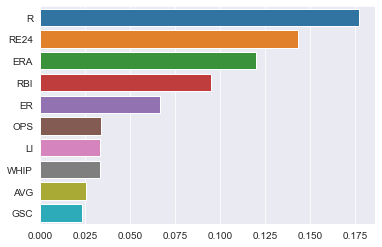

In [38]:
rf_top10 = rf_feature_importance.sort_values(ascending=False)[:10]

sns.barplot(x=rf_top10, y=rf_top10.index)

In [39]:
rf_feature_importance.sort_values(ascending=False).index[:11]

Index(['R', 'RE24', 'ERA', 'RBI', 'ER', 'OPS', 'LI', 'WHIP', 'AVG', 'GSC',
       'H'],
      dtype='object')